In [1]:
# papermill parameters
aid = 5
print(f'aid={aid}')

aid=5


In [2]:
import torch
from torch import nn
from torch import optim
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

import torchvision
import torchvision.models as models
from torchvision import transforms
from torchvision.utils import save_image
from torchvision.datasets import MNIST

from captum.attr import visualization as viz

import numpy as np
import scipy
from scipy.linalg import orth

import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import pandas as pd

from copy import deepcopy
from tqdm import tqdm
import pickle as pkl
import random

from scipy import ndimage as ndi
from skimage.util import random_noise
from skimage import feature

# our own imports
import util
from util import compute_tangent_space, project_into_tangent_space, normalize_image, dcn

from models import lenet_model_and_optimizer

from MNIST32 import MNIST32, MNIST256

%load_ext autoreload
%autoreload 2

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
#device = torch.device('cpu')
print(device)

cuda


# Task 1: Compute tangent spaces for the train/test data

### parameters to re-create the dataset 10 times with 10 different autoencoders

# aid goes from 0-99 for 10 models with 10 compute batches each
batch_id = aid # TODO make this work also for normal dataset again
if aid is not None:
    model_id = 1 + (aid // 10)
    batch_id = aid % 10

autoencoder_dir = 'disentangling_vae/results/btcvae_mnist'
simplenetfile = './models/mnist_label_simplenet.pth'
if aid is not None:
    autoencoder_dir = f'./models/btcvae_mnist/btcvae_mnist_{model_id}'
    simplenetfile = f'./models/mnist_label_simplenet_{model_id}.pth'
    
mnist = MNIST32(modelfile = autoencoder_dir, simplenetfile = simplenetfile)

MNIST32_X, MNIST32_Y, MNIST32_Z = torch.load('./data/MNIST32_val.pkl')
if aid is not None:
    MNIST32_X, MNIST32_Y, MNIST32_Z = torch.load(f'./data/MNIST32_val_{model_id}.pth') # todo rename the files in pkl 

z_monitor, x_monitor, c_monitor = MNIST32_Z[(1000*batch_id):1000*(batch_id+1)], MNIST32_X[(1000*batch_id):1000*(batch_id+1)], MNIST32_Y[(1000*batch_id):1000*(batch_id+1)]

t_monitor = np.zeros((1000, 10, 32, 32))
for i in tqdm(range(len(z_monitor))):
    z = z_monitor[i, :] 
    
    # tangent space
    z = z.reshape(-1)
    tangent_space = compute_tangent_space(mnist.vae_model, z, device=device)
    tangent_space = tangent_space.cpu().numpy()
    tangent_space = orth(tangent_space.reshape((-1, 32*32)).T).T.reshape((-1, 32, 32)) # orthogonalize the tangent space
    if tangent_space.shape[0] == 9: # this happens for 1 observation in the training set
        print(f'Numeric dimension of the tangent space for the observation at index {i} is only 9')
        tangent_space_10 = np.zeros((10, 32, 32))
        tangent_space_10[0:9, :, :] = tangent_space
        tangent_space = tangent_space_10
    t_monitor[i, :, :, :] = tangent_space
    
pkl.dump(t_monitor, open(f'./output/mnist_32_{model_id}_val_tangent_space_{batch_id}.pkl', 'wb+'))

sdfasdfasdf # secret command to interrupt the kernel and end the notebook execution at this point

### aggregate results (run only once)

MNIST32_T = np.zeros((10000, 10, 32, 32), dtype=np.float32)
for i in range(10):
    t_monitor = pkl.load( open(f'./output/mnist_32_007_val_tangent_space_{i}.pkl', 'rb') )
    MNIST32_T[(1000*i):1000*(i+1), :, :, :] = t_monitor

torch.save((MNIST32_X, MNIST32_Y, MNIST32_Z, MNIST32_T), open(f'data/MNIST32_val_final_007.pkl', 'wb+'))

for model_id in tqdm(range(1, 11)):
    MNIST32_X, MNIST32_Y, MNIST32_Z = torch.load(f'./data/MNIST32_val_{model_id}.pth')
    MNIST32_T = np.zeros((10000, 10, 32, 32), dtype=np.float32)
    for batch_id in range(10):
        t_monitor = pkl.load( open(f'./output/mnist_32_{model_id}_val_tangent_space_{batch_id}.pkl', 'rb') )
        MNIST32_T[(1000*batch_id):1000*(batch_id+1), :, :, :] = t_monitor
    torch.save((MNIST32_X, MNIST32_Y, MNIST32_Z, MNIST32_T), open(f'data/MNIST32_val_final_{model_id}.pkl', 'wb+'))

# Task 2: Train a model and optionally monitor it during training

## data

#### parameter for the 10 different replication dataset

In [3]:
# aid goes from 1-10 for the 10 replication dataset
model_id = aid

traindata = f'./data/MNIST32_train_{model_id}.pth'
testdata = f'./data/MNIST32_val_final_{model_id}.pkl'

In [4]:
# default
#traindata = './data/MNIST32_train.pkl'
#testdata = './data/MNIST32_val.pkl'

In [5]:
x, y, _ = torch.load(traindata)
trainset = torch.utils.data.TensorDataset(x, y)
trainloader = DataLoader(trainset, batch_size=32, shuffle=True)

x, y, _, _ = torch.load(testdata)
testset = torch.utils.data.TensorDataset(x, y)
testloader = DataLoader(testset, batch_size=32, shuffle=True)

### Load the evaluation data on which we evaluate the model during training

In [6]:
#z_monitor, x_monitor, c_monitor, t_monitor = pkl.load(open('./output/mnist_monitor_32_1000.pkl', 'rb'))
#print(len(t_monitor))

In [7]:
x_monitor, c_monitor, z_monitor, t_monitor = torch.load(testdata)
print(len(t_monitor))

10000


## Train LeNet

#### also monitor how class gradients evolve during training

In [3]:
def model_and_optimizer():
    return lenet_model_and_optimizer(lr=1e-3)

In [9]:
model, optimizer = model_and_optimizer()

In [10]:
# decrease the learning rate over time
scheduler = StepLR(optimizer, step_size=10, gamma=0.1)

In [11]:
gradient_steps_to_monitor = list(range(21))
gradient_steps_to_monitor.extend([25*i for i in range(1, 25)])
gradient_steps_to_monitor.extend([600 + 100*i for i in range(1, 15)])
gradient_steps_to_monitor.extend([2000 + 1000*i for i in range(1, 100)])

In [12]:
N = 500 # size of evaluation dataset
inputs = [x_monitor[i, :, :, :] for i in range(N)]
model.to(device)
ce_loss = torch.nn.CrossEntropyLoss()
num_gradient_steps = 0
gradient_step_monitoring = {}

for i_epoch in range(50):    
    print(f' --- Epoch {i_epoch} --- ')
    # gradient descent on the dataset
    ce_loss = torch.nn.CrossEntropyLoss()
    model.train()
    train_loss = 0
    train_zero_one_loss = 0
    for img, label in trainloader:
        # monitoring
        #if num_gradient_steps in gradient_steps_to_monitor: 
        if False:
            print(f'Monitoring after {num_gradient_steps} gradient steps.')
            grad_list, int_grad_list, igx_list = util.compute_saliency_maps(model, inputs)
            smooth_grad_list = [util.smooth_grad(model, img, 0.02, 25) for img in inputs]
            # compute and store fractions
            test_zero_one_loss = util.test(model, testloader, device, verbose=False)
            frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor[:N])
            frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor[:N])
            frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor[:N]) 
            frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor[:N])
            gradient_step_monitoring[num_gradient_steps] = [np.mean(frac_grad_its), 
                                                            np.mean(frac_smooth_grad_its), 
                                                            np.mean(frac_int_grad_its), 
                                                            np.mean(frac_ixg_its),
                                                            test_zero_one_loss]
            # resume training 
            model.train()
            
        # take a single gradient step
        img, label = img.to(device), label.to(device)
        pred = model(img)
        optimizer.zero_grad()
        loss = ce_loss(pred, label)
        loss.backward()
        train_loss += loss.item()  
        train_zero_one_loss += (pred.softmax(dim=1).argmax(dim=1) != label).sum().item()
        optimizer.step()
        num_gradient_steps += 1
    train_zero_one_loss = train_zero_one_loss / len(trainloader.dataset)
    print('Train Error: ', train_zero_one_loss)
    
    util.test(model, testloader, device)
    scheduler.step()

 --- Epoch 0 --- 
Train Error:  0.08068333333333333
Test Error:  0.0274
 --- Epoch 1 --- 
Train Error:  0.0382
Test Error:  0.0188
 --- Epoch 2 --- 
Train Error:  0.03141666666666667
Test Error:  0.0178
 --- Epoch 3 --- 


KeyboardInterrupt: 

In [ ]:
torch.save(model.state_dict(), f'./models/mnist32_lenet_replication_{model_id}.pth')

In [ ]:
#torch.save(gradient_step_monitoring, f'/mnt/qb/luxburg/sbordt10/explanations-manifold/output/mnist32_lenet_gradient_step_monitoring_{aid}')
#torch.save(model.state_dict(), f'/mnt/qb/luxburg/sbordt10/explanations-manifold/models/mnist32_lenet_{aid}.pth')

# Quantitative Evaluation: Histograms with fraction in tangent space for different methods

In [ ]:
# load a previously trained model
model.eval()
util.test(model, testloader, device)

In [ ]:
inputs = [x_monitor[i, :, :, :] for i in range(len(t_monitor))]
grad_list, int_grad_list, igx_list = util.compute_saliency_maps(model, inputs)

In [ ]:
smooth_grad_list = [util.smooth_grad(model, img, 0.02, 25) for img in inputs]

In [ ]:
frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor)
frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor)
frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor) 
frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor)

np.mean(frac_grad_its), np.mean(frac_smooth_grad_its), np.mean(frac_int_grad_its), np.mean(frac_ixg_its)

In [ ]:
val_pair = []
for v in frac_grad_its:
    val_pair.append((v, 'Gradient'))
for v in frac_smooth_grad_its:
    val_pair.append((v, 'SmoothGrad'))
for v in frac_int_grad_its:
    val_pair.append((v, 'Integrated Gradient'))
for v in frac_ixg_its:
    val_pair.append((v, 'Input X Gradient'))
df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
sns.set_style('whitegrid')
plt.figure(figsize=(9, 6))
# sns.set(rc={'figure.figsize':(28,13)})
sns.kdeplot(data=df, x='Value', hue='Method', fill=True, linewidth=2, alpha=0.3)
plt.axvline(np.sqrt(10/32**2), 0, 1.4, label='Random', color='gray', lw=5)
#plt.legend(labels=['Random', 'Input x Gradient', 'Integrated Gradients', 'SmoothGrad', 'Gradient'], fontsize=24) #  , loc='upper left'
plt.xlim([0., .85])
plt.xticks(fontsize=24, rotation=45)
plt.xlabel('Fraction in tangent space', fontsize=24)
plt.yticks(fontsize=24)
plt.ylabel('Density', fontsize=24)
plt.savefig(f'figures/mnist-32-methods-{model_id}.pdf')
plt.show()

In [ ]:
ddjdjdjddsfa # secret command to interrupt the kernel and end the compute job

## Aggregate the results from the 10 replications and produce plot in the appendix

10000


5it [00:00, 45.94it/s]

Test Error:  0.0107


10000it [01:49, 91.17it/s]


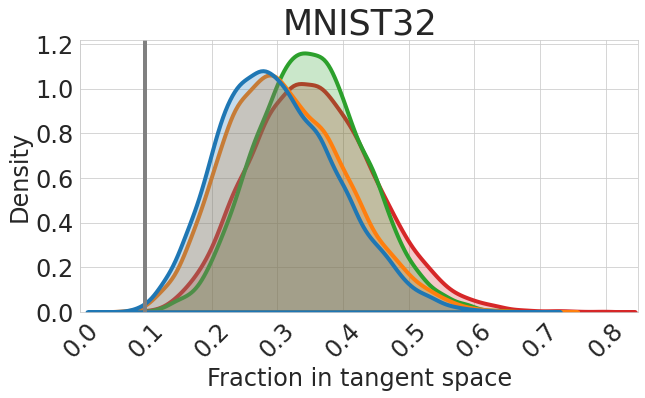

10000


9it [00:00, 88.72it/s]

Test Error:  0.0106


10000it [01:50, 90.22it/s]


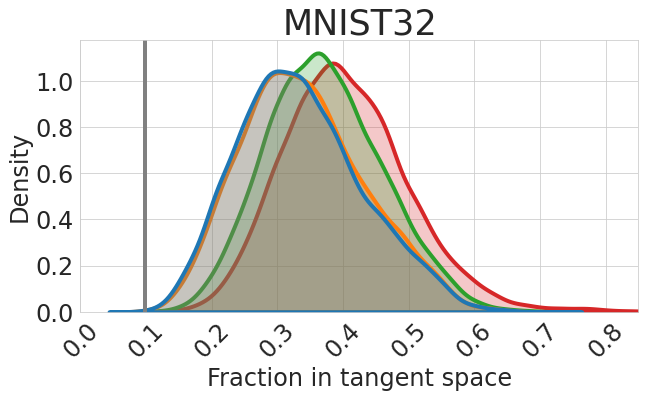

10000


0it [00:00, ?it/s]

Test Error:  0.0106


10000it [01:52, 88.91it/s]


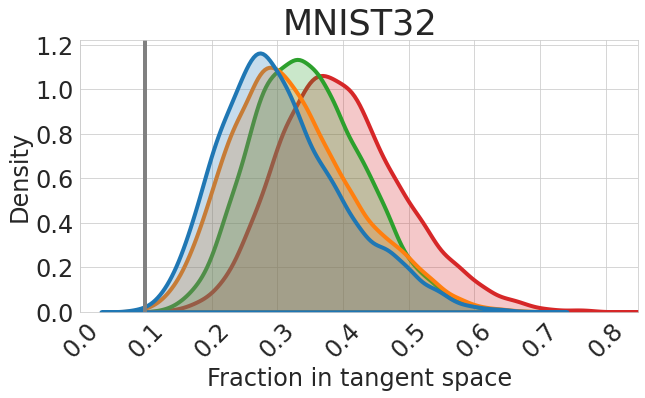

10000


9it [00:00, 85.18it/s]

Test Error:  0.0107


10000it [01:53, 87.86it/s]


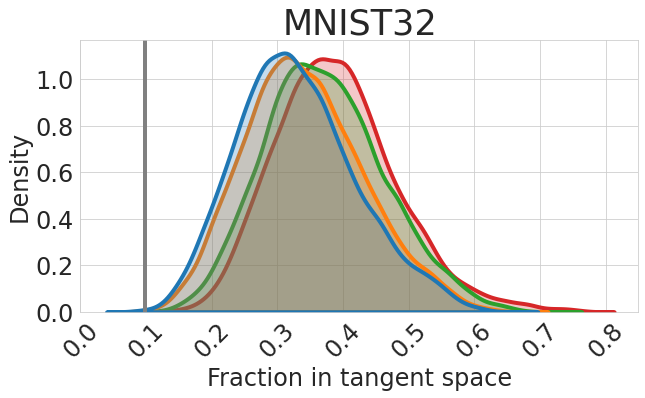

10000


9it [00:00, 85.95it/s]

Test Error:  0.009


10000it [01:53, 88.27it/s]


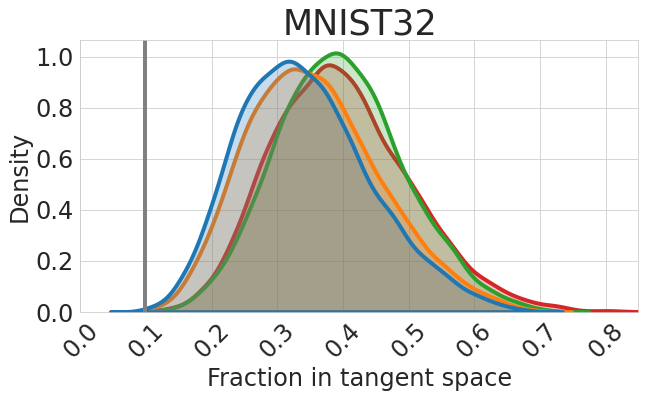

10000


9it [00:00, 86.55it/s]

Test Error:  0.0096


10000it [01:53, 88.01it/s]


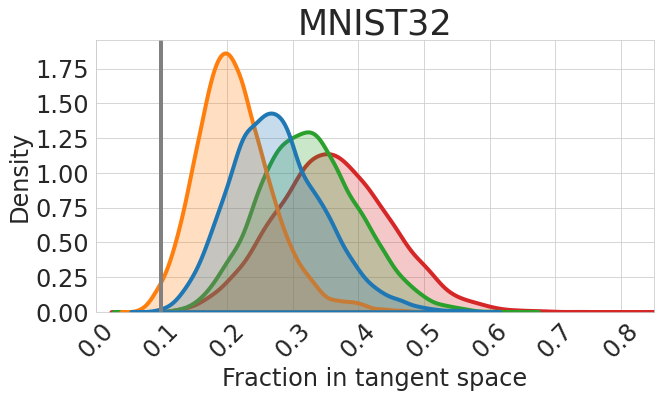

10000


0it [00:00, ?it/s]

Test Error:  0.0122


10000it [01:53, 87.92it/s]


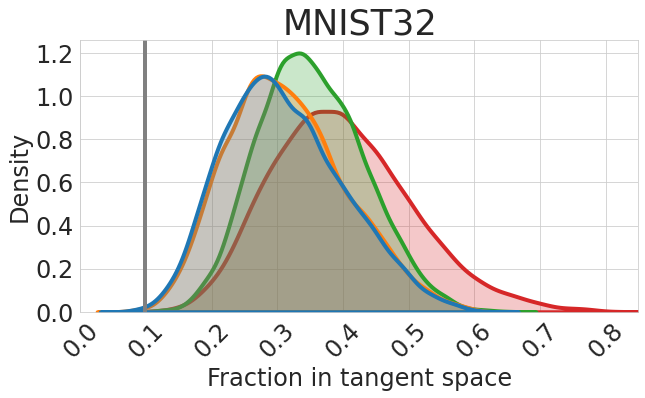

10000


9it [00:00, 86.49it/s]

Test Error:  0.0107


10000it [01:53, 87.88it/s]


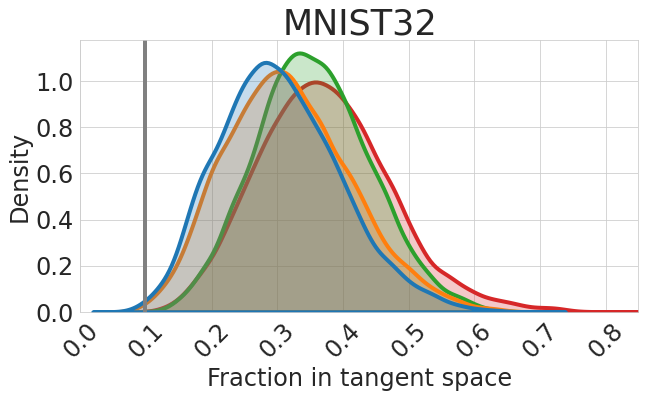

10000


9it [00:00, 86.04it/s]

Test Error:  0.0093


10000it [01:53, 87.92it/s]


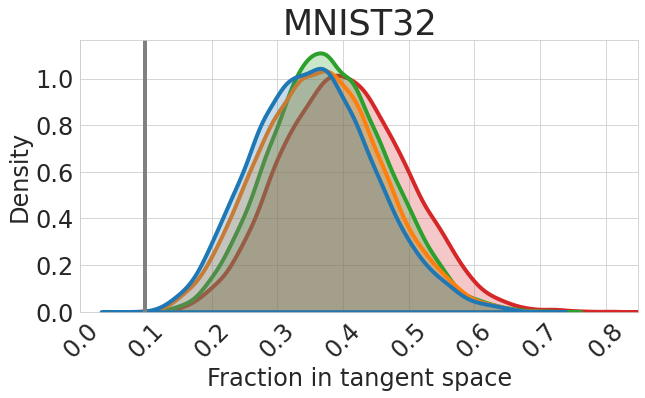

10000


9it [00:00, 86.72it/s]

Test Error:  0.0087


10000it [01:53, 87.81it/s]


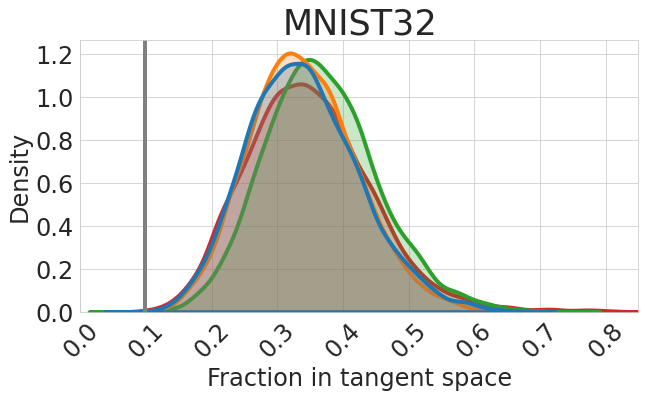

In [4]:
for replication_id in range(1, 11):
    testdata = f'./data/MNIST32_val_final_{replication_id}.pkl'
    
    x, y, _, _ = torch.load(testdata)
    testset = torch.utils.data.TensorDataset(x, y)
    testloader = DataLoader(testset, batch_size=32, shuffle=True)
    
    x_monitor, c_monitor, z_monitor, t_monitor = torch.load(testdata)
    print(len(t_monitor))
    
    # load a previously trained model
    model, _ = model_and_optimizer()
    model.load_state_dict(torch.load(f'./models/mnist32_lenet_replication_{replication_id}.pth'))
    model.to(device)
    model.eval()
    util.test(model, testloader, device)
    
    # compute saliency maps
    inputs = [x_monitor[i, :, :, :] for i in range(len(t_monitor))]
    grad_list, int_grad_list, igx_list = util.compute_saliency_maps(model, inputs)
    smooth_grad_list = [util.smooth_grad(model, img, 0.02, 25) for img in inputs]
    
    # fractions
    frac_grad_its = util.tangent_space_ratio(grad_list, t_monitor)
    frac_smooth_grad_its = util.tangent_space_ratio(smooth_grad_list, t_monitor)
    frac_int_grad_its = util.tangent_space_ratio(int_grad_list, t_monitor) 
    frac_ixg_its = util.tangent_space_ratio(igx_list, t_monitor)

    np.mean(frac_grad_its), np.mean(frac_smooth_grad_its), np.mean(frac_int_grad_its), np.mean(frac_ixg_its)
    
    # plot
    val_pair = []
    for v in frac_grad_its:
        val_pair.append((v, 'Gradient'))
    for v in frac_smooth_grad_its:
        val_pair.append((v, 'SmoothGrad'))
    for v in frac_int_grad_its:
        val_pair.append((v, 'Integrated Gradient'))
    for v in frac_ixg_its:
        val_pair.append((v, 'Input X Gradient'))
    df = pd.DataFrame(data=val_pair, columns=['Value', 'Method'])
    sns.set_style('whitegrid')

    plt.figure(figsize=(10, 5))
    sns.kdeplot(data=df, x='Value', hue='Method', fill=True, legend=False, lw=4, alpha=0.25)
    plt.axvline(np.sqrt(10/32**2), 0, 1.4, label='Random', color='gray', lw=4)
    #plt.legend(labels=['Random', 'Input x Gradient', 'Integrated Gradients', 'SmoothGrad', 'Gradient'], fontsize=24) #  , loc='upper left'
    plt.xlim([0., .85])
    plt.xticks(fontsize=24, rotation=45)
    plt.xlabel('Fraction in tangent space', fontsize=24)
    #plt.xlabel('', fontsize=24)
    plt.yticks(fontsize=24)
    plt.ylabel('Density', fontsize=24)
    #plt.ylabel('', fontsize=24)
    plt.title('MNIST32', fontsize=35)
    plt.savefig(f'./figures/mnist_32_methods_replication_{replication_id}.pdf', bbox_inches='tight')
    plt.show()